<a href="https://colab.research.google.com/github/barak33/AI-Specialization/blob/master/SDG_HEALTH_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install pandas numpy scikit-learn xgboost shap matplotlib plotly

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Simulated dataset based on UN SDG indicators
data = {
    'Country': ['CountryA']*60 + ['CountryB']*60,
    'Month': list(range(1,13))*5 + list(range(1,13))*5,
    'Year': [2020]*12 + [2021]*12 + [2022]*12 + [2023]*12 + [2024]*12 + [2020]*12 + [2021]*12 + [2022]*12 + [2023]*12 + [2024]*12,
    'TB_Incidence': np.random.normal(150, 20, 120),  # SDG 3.3.2
    'Malaria_Cases': np.random.poisson(50, 120),     # SDG 3.3.3
    'Vaccination_Coverage': np.random.uniform(60, 95, 120),  # SDG 3.b.1
    'Avg_Temperature': np.random.uniform(20, 35, 120),  # Climate factor
    'Outbreak_Occurred': np.random.choice([0, 1], 120, p=[0.85, 0.15])  # Target
}

df = pd.DataFrame(data)

# Feature engineering: Add temporal trends
df['Cases_3mo_Avg'] = df.groupby('Country')['Malaria_Cases'].rolling(3).mean().reset_index(level=0, drop=True)
df['Temp_Anomaly'] = df['Avg_Temperature'] - df.groupby('Country')['Avg_Temperature'].transform('mean')

# Handle missing values
df.fillna(method='ffill', inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, columns=['Country'])

# Split data
X = df.drop(['Outbreak_Occurred', 'Month', 'Year'], axis=1)
y = df['Outbreak_Occurred']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

/tmp/ipython-input-14-656761060.py:24: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [15]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, matthews_corrcoef

# Base models
xgb = XGBClassifier(random_state=42, scale_pos_weight=5)  # Handle class imbalance
rf = RandomForestClassifier(random_state=42)

# Train individual models
xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Evaluate
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f"MCC: {matthews_corrcoef(y_test, y_pred):.3f}")

print("XGBoost Performance:")
evaluate_model(xgb, X_test, y_test)

print("\nRandom Forest Performance:")
evaluate_model(rf, X_test, y_test)

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.50      0.25      0.33         4

    accuracy                           0.83        24
   macro avg       0.68      0.60      0.62        24
weighted avg       0.80      0.83      0.81        24

MCC: 0.270

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        20
           1       0.00      0.00      0.00         4

    accuracy                           0.83        24
   macro avg       0.42      0.50      0.45        24
weighted avg       0.69      0.83      0.76        24

MCC: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



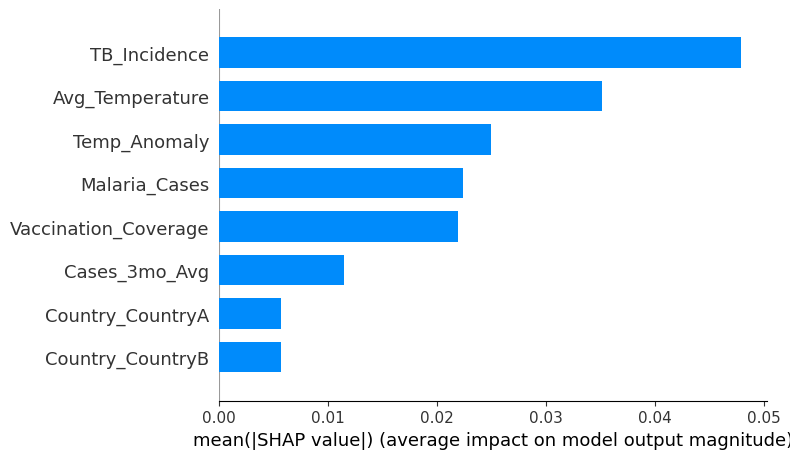

In [16]:
import shap
import numpy as np # Import numpy

# Explain Random Forest predictions
explainer = shap.TreeExplainer(rf)

# For multi-output models (like classification), TreeExplainer returns a list of SHAP values, one for each class
# Or for tree models, it returns a 3D numpy array (samples, features, classes)
# We need to select the SHAP values for the class we are interested in (class 1 - Outbreak_Occurred)
shap_values = explainer.shap_values(X_test)

# Visualize feature importance for class 1
# For classification, shap_values is a list where each element is an array for a class.
# For TreeExplainer with a binary classification model, shap_values is a 3D array (samples, features, classes).
# Let's assume it's the 3D array case based on the traceback and variable shapes.
# We need SHAP values for class 1 (index 1 in the last dimension)
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar")

# Explain individual prediction (highest risk case)
high_risk_idx = np.argmax(rf.predict_proba(X_test)[:, 1])

# Select the SHAP values for the highest risk instance and for class 1
shap_values_single_instance = shap_values[high_risk_idx,:,1]

# The expected_value should also correspond to the expected value for class 1
expected_value_class_1 = explainer.expected_value[1]

shap.force_plot(expected_value_class_1, shap_values_single_instance, X_test.iloc[high_risk_idx,:])

In [17]:
import plotly.express as px

# Generate predictions
df_test = X_test.copy()
df_test['Outbreak_Risk'] = rf.predict_proba(X_test)[:, 1]
df_test['Actual'] = y_test.values

# Simulate geospatial data
df_test['Latitude'] = np.random.uniform(-30, 30, len(df_test))
df_test['Longitude'] = np.random.uniform(-20, 50, len(df_test))

# Create interactive map
fig = px.scatter_geo(df_test,
                    lat='Latitude',
                    lon='Longitude',
                    color='Outbreak_Risk',
                    size='Outbreak_Risk',
                    hover_name='Actual',
                    projection="natural earth",
                    title="Disease Outbreak Risk Prediction")
fig.update_layout(geo=dict(showcountries=True))
fig.show()

In [18]:
# UN SDG API Example (pseudo-code)
# import requests
# url = "https://unstats.un.org/SDGAPI/v1/sdg/Series/Data?seriesCode=SH_TBS_INCD"
# tb_data = requests.get(url).json()

In [19]:
def send_alert(country, risk_score):
    if risk_score > 0.7:
        print(f"ALERT: High outbreak risk in {country} (Risk: {risk_score:.1%})")
        # Integrate with Twilio/Slack in production